In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import custom_module as cm
import optimizer_module as om

In [2]:
# Loading the dataset
data = pd.read_csv("combined_data.csv", parse_dates=True)

In [3]:
# Setting the data to requirement
data["SETTLEMENTDATE"] = pd.to_datetime(data["SETTLEMENTDATE"])
data.index = data["SETTLEMENTDATE"]
data.drop(columns="SETTLEMENTDATE", inplace=True)

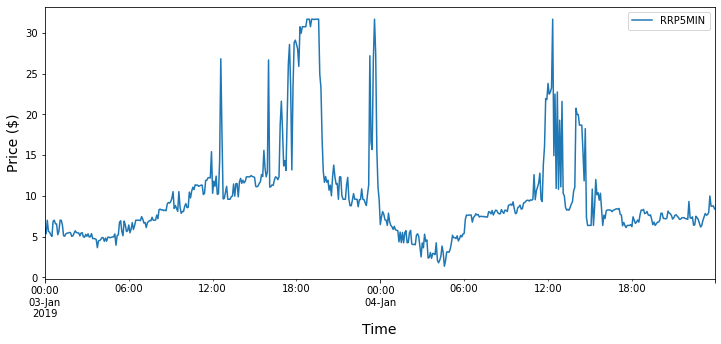

In [4]:
# Plotting the curve Price
cm.plot_chart(data["RRP5MIN"].loc["2019-01-03":"2019-01-04"], legend=True)

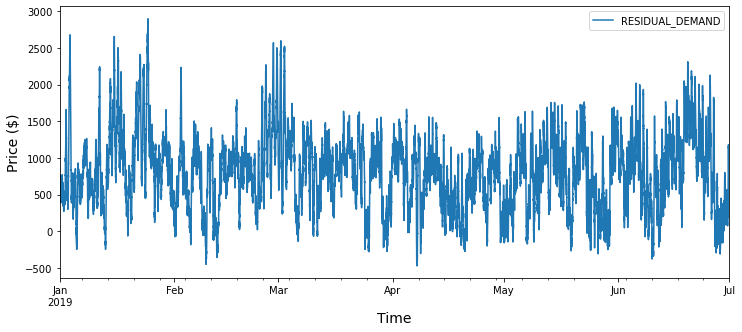

In [5]:
# Plotting the curve Residual Demand
cm.plot_chart(data["RESIDUAL_DEMAND"].loc["2019"], legend=True)

In [6]:
# The Real Test Data Set To Test Later #
X_test = data["2019-01-01":"2019-06-30"].copy()
X_test = X_test["RRP5MIN"]

In [7]:
# replace outliers by outlier threshold
data = cm.replace_outliers(data, 'RRP5MIN', 4)

In [8]:
data.head(5)

,RRP5MIN,RESIDUAL_DEMAND
SETTLEMENTDATE,,
2010-10-20 00:00:00,1.963450,1296.50
2010-10-20 00:05:00,1.955553,1275.46
2010-10-20 00:10:00,1.946951,1268.40
2010-10-20 00:15:00,1.953207,1267.73
2010-10-20 00:20:00,1.835252,1261.69


In [9]:
# Scaling the RRP between 0 and 1 as required by the NN
feature_scaler = MinMaxScaler()
data["RESIDUAL_DEMAND"] = feature_scaler.fit_transform(pd.DataFrame(data["RESIDUAL_DEMAND"]))

In [10]:
# scale price data to 0-1 range
label_scaler = MinMaxScaler()
data['RRP5MIN'] = label_scaler.fit_transform(data['RRP5MIN'].values.reshape(-1, 1))

In [11]:
train = data.loc["2017":].copy()
yearly_lags_creater = data.loc["2016":].copy()
weekly_lags_creater = data.loc["2016-12-25":].copy()

In [12]:
print(train.loc["2017"])

                      RRP5MIN  RESIDUAL_DEMAND
SETTLEMENTDATE                                
2017-01-01 00:00:00  0.452476         0.504247
2017-01-01 00:05:00  0.668124         0.495465
2017-01-01 00:10:00  0.668124         0.490768
2017-01-01 00:15:00  0.885617         0.493810
2017-01-01 00:20:00  0.564586         0.487734
...                       ...              ...
2017-12-31 23:35:00  0.628874         0.483414
2017-12-31 23:40:00  0.629760         0.486110
2017-12-31 23:45:00  0.621871         0.484464
2017-12-31 23:50:00  0.623247         0.489628
2017-12-31 23:55:00  0.593791         0.484546

[105120 rows x 2 columns]


In [13]:
# include time lags of timeseries data for 3 days = 864
# We will use 3 days data to identify patterns to predict the next day

# Creating Daily lags
j = 1
for i in range(1,289):
    train["d_l_{}".format(j)] = train["RRP5MIN"].shift(i)
    j+=1

# Creating Week ago lags
j = 1
for i in range(1, 289):
    train["w_l_{}".format(j)] = weekly_lags_creater["RRP5MIN"].shift(-i)
    j+=1

'''
# Creating Month ago lags
j = 1
for i in range(1728,2016):
    train["w_l_{}".format(j)] = train["RRP5MIN"].shift(i)
    j++
        
'''
# Creating year ago lags
j = 1
for i in range(1,289):
    train["y_l_{}".format(j)] = yearly_lags_creater["RRP5MIN"].shift(-i)
    j+=1

In [14]:
# Drop NANS
train.dropna(inplace=True)
train.head(5)

,RRP5MIN,RESIDUAL_DEMAND,d_l_1,d_l_2,d_l_3,d_l_4,d_l_5,d_l_6,d_l_7,d_l_8,...,y_l_279,y_l_280,y_l_281,y_l_282,y_l_283,y_l_284,y_l_285,y_l_286,y_l_287,y_l_288
SETTLEMENTDATE,,,,,,,,,,,,,,,,,,,,,
2017-01-02 00:00:00,0.435896,0.361571,0.435862,0.436410,0.435921,0.455780,0.460233,0.419181,0.409338,0.408725,...,0.392523,0.391806,0.392052,0.392581,0.447287,0.411644,0.410932,0.397431,0.410564,0.395403
2017-01-02 00:05:00,0.441738,0.354074,0.435896,0.435862,0.436410,0.435921,0.455780,0.460233,0.419181,0.409338,...,0.391806,0.392052,0.392581,0.447287,0.411644,0.410932,0.397431,0.410564,0.395403,0.396365
2017-01-02 00:10:00,0.447377,0.344578,0.441738,0.435896,0.435862,0.436410,0.435921,0.455780,0.460233,0.419181,...,0.392052,0.392581,0.447287,0.411644,0.410932,0.397431,0.410564,0.395403,0.396365,0.397510
2017-01-02 00:15:00,0.471647,0.342912,0.447377,0.441738,0.435896,0.435862,0.436410,0.435921,0.455780,0.460233,...,0.392581,0.447287,0.411644,0.410932,0.397431,0.410564,0.395403,0.396365,0.397510,0.394450
2017-01-02 00:20:00,0.436184,0.328908,0.471647,0.447377,0.441738,0.435896,0.435862,0.436410,0.435921,0.455780,...,0.447287,0.411644,0.410932,0.397431,0.410564,0.395403,0.396365,0.397510,0.394450,0.397747


In [15]:
# create feature and label dataframes
prelim_features = train.drop(['RRP5MIN', 'RESIDUAL_DEMAND'], axis=1)
prelim_labels = pd.DataFrame(train[['RRP5MIN']])

In [16]:
# format labels to 24 hour output range
for i in range(0, 288):
    prelim_labels['t_{}'.format(i)] = prelim_labels['RRP5MIN'].shift(-i)
prelim_labels.drop(['RRP5MIN'], axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.minute == 0]
labels = labels[labels.index.hour == 0]
features = prelim_features[prelim_features.index.minute == 0]
features = features[features.index.hour == 0]

features_train = features[:'2018']
features_test = features['2019':'2019-06-30']
labels_train = labels[:'2018']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 864

# convert pandas data frames to numpy ndarrays
features_train = features_train.to_numpy().reshape(samples_train, timesteps, 1)
features_test = features_test.to_numpy().reshape(samples_test, timesteps, 1)
labels_train = labels_train.to_numpy()

# check for correct data shape
features_train.shape, labels_train.shape

((729, 864, 1), (729, 288))

In [17]:
from keras.models import Model, load_model
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
import tensorflow as tf

In [18]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

In [19]:
###################### DESIGNING THE NN ###################
##########################################################
## 1D Convolution layer to avoid overfitting
## 3 layers of LSTM considering the complexity of the dataset
# Initialising
rnn = Sequential()
# Adding Conv1D Layer
rnn.add(Conv1D(128, kernel_size=288, strides=288, padding='valid', input_shape=(X_train.shape[1],1)))
# Add LSTM layer 1st
rnn.add(LSTM(200, recurrent_activation='sigmoid', return_sequences=True))
rnn.add(Dropout(0.1))
# Add LSTM layer 2nd
rnn.add(LSTM(128, recurrent_activation='sigmoid'))
rnn.add(Dropout(0.1))
rnn.add(Dense(units=288))
rnn.compile(optimizer='adam', loss='mae') ################ CHANGED LOSS TO MSE #################

In [20]:
#model.compile(loss='mae', optimizer='adam')
checkpoint = ModelCheckpoint('./models/multidim_timeseries_testing.hdf5', save_best_only=True)

hist = rnn.fit(X_train, y_train,
                 validation_data=(X_valid, y_valid),
                 callbacks=[checkpoint], 
                 verbose=1, batch_size=32, epochs=160)

Epoch 1/160
19/19 [==============================] - 1s 49ms/step - loss: 0.3065 - val_loss: 0.0978
Epoch 2/160
19/19 [==============================] - 0s 13ms/step - loss: 0.1113 - val_loss: 0.0724
Epoch 3/160
19/19 [==============================] - 0s 10ms/step - loss: 0.0960 - val_loss: 0.0666
Epoch 4/160
19/19 [==============================] - 0s 10ms/step - loss: 0.0858 - val_loss: 0.0650
Epoch 5/160
19/19 [==============================] - 0s 9ms/step - loss: 0.0793 - val_loss: 0.0592
Epoch 6/160
19/19 [==============================] - 0s 9ms/step - loss: 0.0733 - val_loss: 0.0532
Epoch 7/160
19/19 [==============================] - 0s 9ms/step - loss: 0.0705 - val_loss: 0.0515
Epoch 8/160
19/19 [==============================] - 0s 10ms/step - loss: 0.0684 - val_loss: 0.0508
Epoch 9/160
19/19 [==============================] - 0s 8ms/step - loss: 0.0673 - val_loss: 0.0571
Epoch 10/160
19/19 [==============================] - 0s 7ms/step - loss: 0.0666 - val_loss: 0.0562
Epoc

Epoch 83/160
19/19 [==============================] - 0s 7ms/step - loss: 0.0449 - val_loss: 0.0399
Epoch 84/160
19/19 [==============================] - 0s 8ms/step - loss: 0.0418 - val_loss: 0.0386
Epoch 85/160
19/19 [==============================] - 0s 8ms/step - loss: 0.0415 - val_loss: 0.0404
Epoch 86/160
19/19 [==============================] - 0s 7ms/step - loss: 0.0426 - val_loss: 0.0401
Epoch 87/160
19/19 [==============================] - 0s 9ms/step - loss: 0.0425 - val_loss: 0.0382
Epoch 88/160
19/19 [==============================] - 0s 7ms/step - loss: 0.0412 - val_loss: 0.0408
Epoch 89/160
19/19 [==============================] - 0s 8ms/step - loss: 0.0423 - val_loss: 0.0452
Epoch 90/160
19/19 [==============================] - 0s 8ms/step - loss: 0.0429 - val_loss: 0.0399
Epoch 91/160
19/19 [==============================] - 0s 8ms/step - loss: 0.0413 - val_loss: 0.0395
Epoch 92/160
19/19 [==============================] - 0s 8ms/step - loss: 0.0411 - val_loss: 0.0406


In [21]:
X_train.shape

(583, 864, 1)

In [22]:
best = load_model('./models/multidim_timeseries_testing.hdf5')
# pred = best.predict([input_test, input_test[:, :, 3]])
pred = best.predict(features_test)
#pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [23]:
pred = label_scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [24]:
results = pd.DataFrame({'prediction':pred.flatten(), 'true values':X_test}, index=X_test.index)

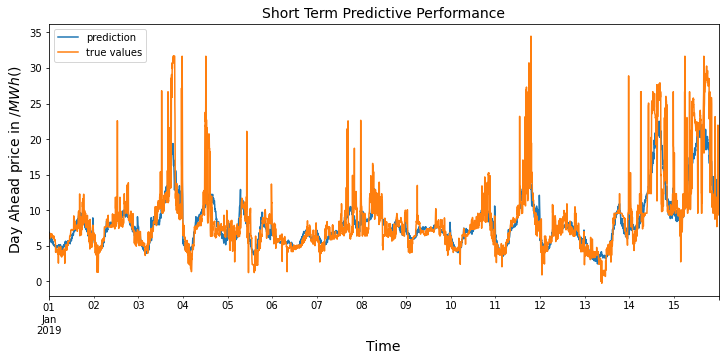

In [41]:
cm.plot_chart(results.loc['2019-01-01':'2019-1-15'], xlab='Time', ylab='Day Ahead price in $/MWh ($)', title='Short Term Predictive Performance', legend=True)

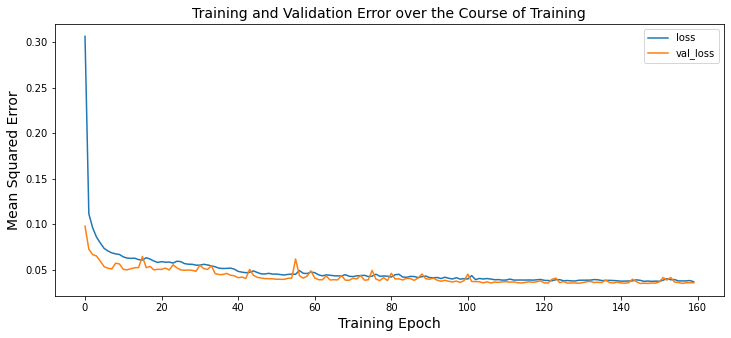

In [26]:
# Training loss comparision
cm.plot_chart(pd.DataFrame(hist.history), xlab='Training Epoch', ylab='Mean Squared Error', title='Training and Validation Error over the Course of Training', legend=True)

In [27]:
# Quantifying Performance using MAE, MSE, RMSE
cm.quantify_performance(results)

MAE:  3.624941934924391
MSE:  2278.9245875833776
RMSE:  47.73808319971988


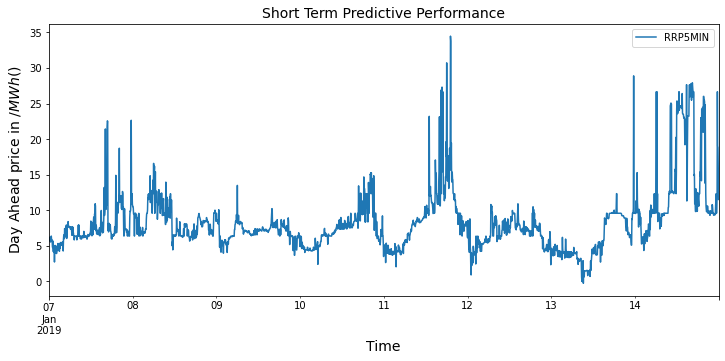

In [28]:
cm.plot_chart(X_test.loc['2019-01-07':'2019-01-14'], xlab='Time', ylab='Day Ahead price in $/MWh ($)', title='Short Term Predictive Performance', legend=True)

In [29]:
results

,prediction,true values
SETTLEMENTDATE,,
2019-01-01 00:00:00,6.467669,6.583450
2019-01-01 00:05:00,6.927527,6.375000
2019-01-01 00:10:00,6.822542,6.438173
2019-01-01 00:15:00,6.594009,6.375000
2019-01-01 00:20:00,6.335266,6.375000
...,...,...
2019-06-30 23:35:00,7.311433,6.134757
2019-06-30 23:40:00,6.569975,5.998145
2019-06-30 23:45:00,6.098683,5.961220


In [30]:
data.shift(-1).loc["2019-01-01"]

,RRP5MIN,RESIDUAL_DEMAND
SETTLEMENTDATE,,
2019-01-01 00:00:00,0.550310,0.383497
2019-01-01 00:05:00,0.552126,0.380347
2019-01-01 00:10:00,0.550310,0.375382
2019-01-01 00:15:00,0.550310,0.372017
2019-01-01 00:20:00,0.540739,0.369414
...,...,...
2019-01-01 23:35:00,0.580803,0.345409
2019-01-01 23:40:00,0.571913,0.347593
2019-01-01 23:45:00,0.557344,0.349098


In [40]:
# Input prices into optimizer
import optimizer_module as om
numDays = 105 # Number of days to run model
start = 0 # Starting time interval from price data
bStorage0 = 0 # Starting battery charge

predPrices = results.iloc[start:start+(numDays*288)]["prediction"].tolist()
realPrices = results.iloc[start:start+(numDays*288)]["true values"].tolist()
outputResults = 1 # Tells optimizer_module to ouput results for each optimization
outputActions = 1 # Tells optimizer_module to puput list of actions/states for battery use

print("Optimizing results for real prices")
realNxtAction, realNxtBatCharge, realActions = om.optimize(realPrices, bStorage0, outputResults, outputActions)

print("\nOptimizing results for predicted prices\nProfit is incorrect as it is calculating predicted profit not actual profit")
predNxtAction, predNxtBatCharge, predActions = om.optimize(predPrices, bStorage0, outputResults, outputActions)

maxProfit = sum([realActions[i]*realPrices[i]/12 for i in range(numDays*288)])
actualProfit = sum([predActions[i]*realPrices[i]/12 for i in range(numDays*288)])

print("\n----------RESULTS----------")
print("Max profit possible: $%.4g" % (maxProfit))
print("Actual profit: $%.4g -> %.4g%% of optimal profit" % (actualProfit,actualProfit/maxProfit*100))    

Optimizing results for real prices

Model objective value: -8145
Predicted profit = $8145 -> 2e+02% Profit
Charged 636.9 MW over 7821 charge intervals (Lost 121 MW due to battery inefficiency)
Discharged 515.9 MW over 6334 discharge intervals
Did nothing during 16085 time intervals
Min price: $-83.33, Max price: $1208

Optimizing results for predicted prices
Profit is incorrect as it is calculating predicted profit not actual profit

Model objective value: -1092
Predicted profit = $1092 -> 51% Profit
Charged 335.8 MW over 4110 charge intervals (Lost 63.81 MW due to battery inefficiency)
Discharged 272 MW over 3308 discharge intervals
Did nothing during 22822 time intervals
Min price: $-0.8845, Max price: $26.35

----------RESULTS----------
Max profit possible: $8145
Actual profit: $4902 -> 60.18% of optimal profit


In [32]:
%reload_ext autoreload

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
